# Preparing data to predict number of deaths

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

PATH_COLLECTED_DATA = './computed/collected_data.csv'
PATH_COLLECTED_DATA_REDUCED = './computed/collected_data_reduced_features.csv'

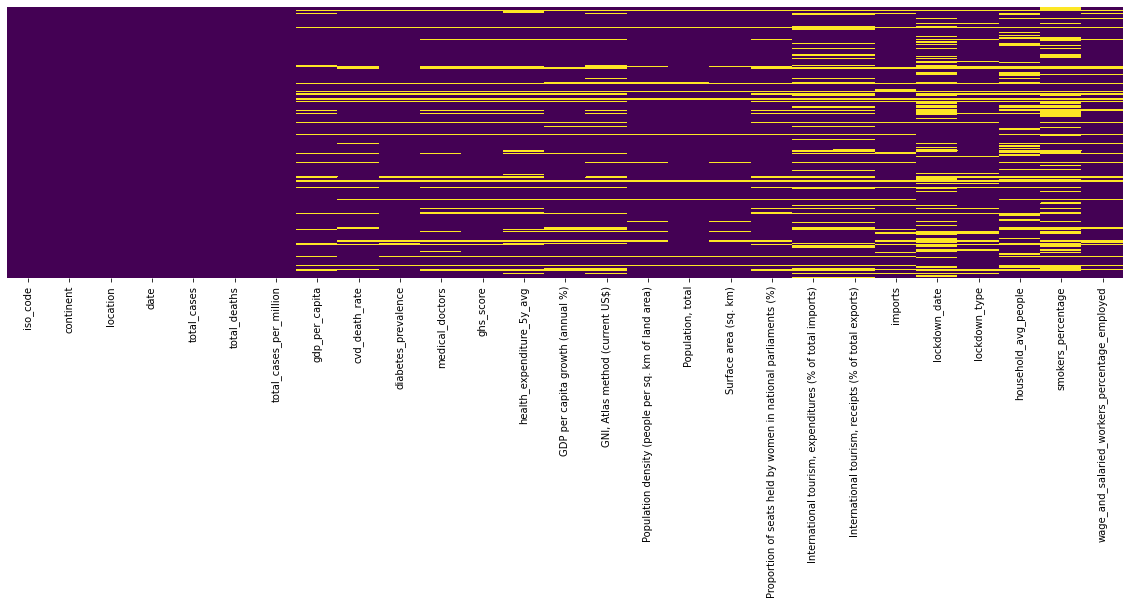

In [2]:
df_complete = pd.read_csv(PATH_COLLECTED_DATA)
df = pd.read_csv(PATH_COLLECTED_DATA_REDUCED)

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

Because it might be easier to predict relative number of deaths, we create the column `total_deaths_per_million` based on absolute number of deaths and population.

In [3]:
total_deaths_per_million = 10**(-6) * df["total_deaths"] / df["Population, total"]
df.insert(loc=0, column='total_deaths_per_million', value=total_deaths_per_million)

We use `gdp_per_capita` as some general indicator for each country. Death rate of cardiovascular diseases and expenditures for the health care system should be a good estimator for the quality of a countries health care system and it's ability to respond to COVID-19.
Additionally we assume that the percentage of smokers says something about the general state of health of the citizens.

In [4]:
df_deaths = df.loc[:, ["total_deaths", "total_deaths_per_million", "gdp_per_capita", "cvd_death_rate",
                       "health_expenditure_5y_avg", "smokers_percentage"]]

(132, 6)


,total_deaths,total_deaths_per_million,gdp_per_capita,cvd_death_rate,health_expenditure_5y_avg,smokers_percentage
total_deaths,1.00,0.41,0.18,-0.19,0.38,0.01
total_deaths_per_million,0.41,1.00,0.38,-0.37,0.38,0.13
gdp_per_capita,0.18,0.38,1.00,-0.47,0.21,0.13
cvd_death_rate,-0.19,-0.37,-0.47,1.00,-0.27,0.21
health_expenditure_5y_avg,0.38,0.38,0.21,-0.27,1.00,0.19
smokers_percentage,0.01,0.13,0.13,0.21,0.19,1.00


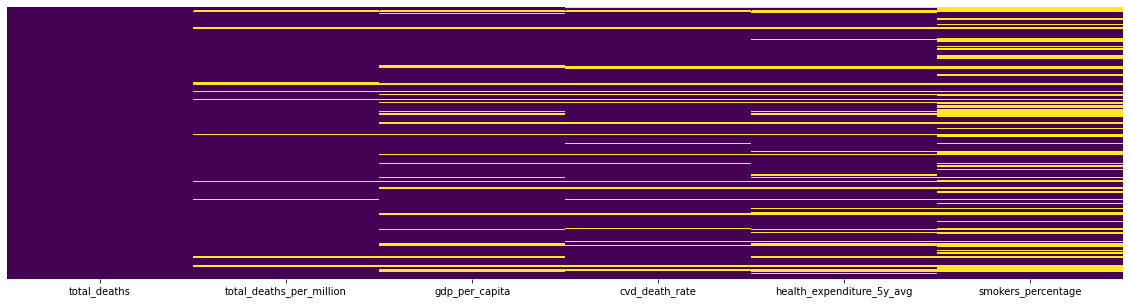

In [5]:
print(df_deaths.dropna().shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_deaths.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_deaths.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

As visible in the correlation matrix we have a correlation of around 47% between `cvd_death_rate` and `gdp_per_capita` which is still ok but should be kept in mind.

Obviously we don't have much datasets for smoker percantage. We want to predict this number based on features with high correlation (we dropped before). In the previous steps where we prepared our data in general we found some attributes with some relatively high correlation compared to percentage of smokers.

(209, 4)


,aged_70_older,medical_doctors,wage_and_salaried_workers_percentage_employed,smokers_percentage
aged_70_older,1.00,0.76,0.63,0.49
medical_doctors,0.76,1.00,0.68,0.48
wage_and_salaried_workers_percentage_employed,0.63,0.68,1.00,0.38
smokers_percentage,0.49,0.48,0.38,1.00


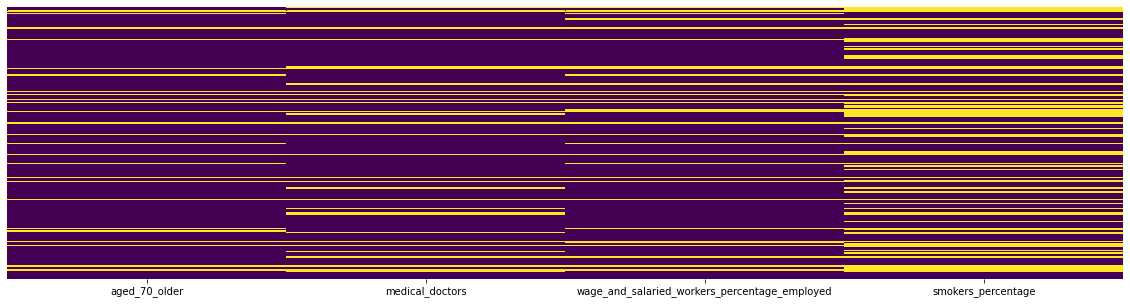

In [6]:
df_smokers = df_complete.loc[:, ["aged_70_older", "medical_doctors"]]
df_smokers["wage_and_salaried_workers_percentage_employed"] = df["wage_and_salaried_workers_percentage_employed"]
df_smokers["smokers_percentage"] = df["smokers_percentage"]

print(df_smokers.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_smokers.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_smokers.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

We create a simple linear regression model to predict the number of smokers based on the other three attributes. We take the datasets where all four values exist to train our model and predict smokers for those datasets where only the smokers percentage is missing but the other three values are known.

(134, 4)
[23.30724111 34.57790682 17.11135509 61.86329787 36.30166344 32.28413803
 18.37928539 31.62710717 29.57912823 26.21145402 60.09661066 19.70592316
 29.33870053 22.5635243  54.63182388 61.99041457 47.34568465 73.38170049
 78.49638069 81.36316687 59.95016285 21.08827056 70.1177006  42.64518663
 52.08010699 46.14337065 42.71690189 19.97189703 47.94021782 65.08336528
 17.70512081 54.20183042 70.65222663 67.74590443 58.68277662]
test:      smokers_percentage
0               29.3705
1               19.4810
2               22.0075
3               27.0530
4               14.7675
..                  ...
129             23.6745
130             18.5080
131             20.7755
132             14.0080
133             16.2955

[134 rows x 1 columns] [45.75622455 83.09806213 68.8245854  58.25885533 75.39259914 79.30774435
 37.28710246 77.12069484 20.95429863 22.0922704  40.56089683 79.17298599
 83.34956684 76.10970912 71.26499753 84.51827514 63.05617295 74.6185615
 79.38430036 64.6505331  75.

,aged_70_older,medical_doctors,wage_and_salaried_workers_percentage_employed,smokers_percentage
aged_70_older,1.00,0.76,0.63,0.10
medical_doctors,0.76,1.00,0.68,0.14
wage_and_salaried_workers_percentage_employed,0.63,0.68,1.00,0.26
smokers_percentage,0.10,0.14,0.26,1.00


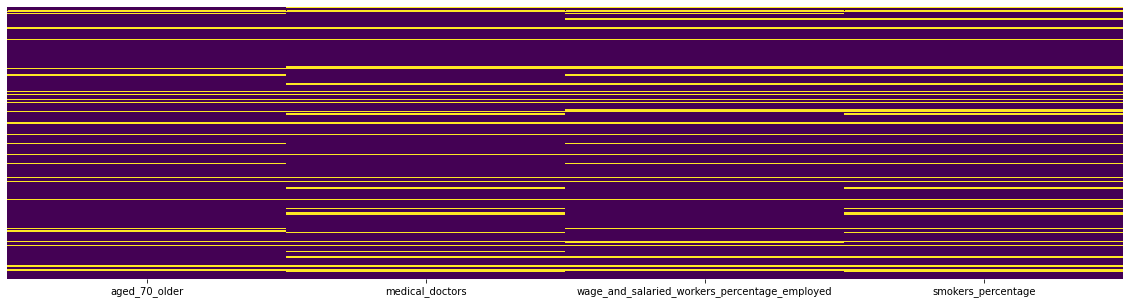

In [7]:
df_smokers_value_exists = df_smokers.dropna()
print(df_smokers_value_exists.shape)

X = df_smokers_value_exists.drop("smokers_percentage", axis=1)
y = df_smokers_value_exists["smokers_percentage"]

regressor = LinearRegression()
regressor.fit(X, y)

X_pred = pd.DataFrame(data={}, columns=['wage_and_salaried_workers_percentage_employed','aged_70_older','medical_doctors'])
X_test = pd.DataFrame(data={}, columns=['wage_and_salaried_workers_percentage_employed','aged_70_older','medical_doctors'])
y_test = pd.DataFrame(data={}, columns=['smokers_percentage'])
i, j = 0, 0
for index, row in df_smokers.iterrows():
    if (math.isnan(row["smokers_percentage"]) and not math.isnan(row["aged_70_older"])
        and not math.isnan(row["medical_doctors"]) and not math.isnan(row["wage_and_salaried_workers_percentage_employed"])):
        # only smokers is unknown, other values are known -> can be predicted
        X_pred.loc[i] = [row["wage_and_salaried_workers_percentage_employed"], row["aged_70_older"], row["medical_doctors"]]
        i+=1
    elif (not math.isnan(row["smokers_percentage"]) and not math.isnan(row["aged_70_older"])
        and not math.isnan(row["medical_doctors"]) and not math.isnan(row["wage_and_salaried_workers_percentage_employed"])):
        # all values are known -> can be used later to evaluate how well the model can predict training data
        X_test.loc[j] = [row["wage_and_salaried_workers_percentage_employed"], row["aged_70_older"], row["medical_doctors"]]
        y_test.loc[j] = [row["smokers_percentage"]]
        j+=1

y_pred = regressor.predict(X_pred)
y_test_pred = regressor.predict(X_test)
print(y_pred)

print("test:", y_test, y_test_pred)

i=0
for index, row in df_smokers.iterrows():
    if (math.isnan(row["smokers_percentage"]) and not math.isnan(row["aged_70_older"])
        and not math.isnan(row["medical_doctors"]) and not math.isnan(row["wage_and_salaried_workers_percentage_employed"])):
        row["smokers_percentage"] = y_pred[i]
        i+=1

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_smokers.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_smokers.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Now we can test our model - comparing actual values and predicted ones. Actually it's our training data, so we should have a good correlation between actual values and predicted ones.

In [8]:
#for i in range(y_test.shape[0]):
#    print(i, y_test.loc[i, "smokers_percentage"], y_test_pred[i])
y_test_compare = y_test.copy()
y_test_compare["pred"] = y_test_pred
corr = y_test_compare.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,smokers_percentage,pred
smokers_percentage,1.00,0.42
pred,0.42,1.00


It doesn't work. Correlation is low and if one compares actual and predicted values it looks like some random values.

(167, 5)


,total_deaths,total_deaths_per_million,gdp_per_capita,cvd_death_rate,health_expenditure_5y_avg
total_deaths,1.00,0.41,0.18,-0.19,0.38
total_deaths_per_million,0.41,1.00,0.38,-0.37,0.38
gdp_per_capita,0.18,0.38,1.00,-0.47,0.21
cvd_death_rate,-0.19,-0.37,-0.47,1.00,-0.27
health_expenditure_5y_avg,0.38,0.38,0.21,-0.27,1.00


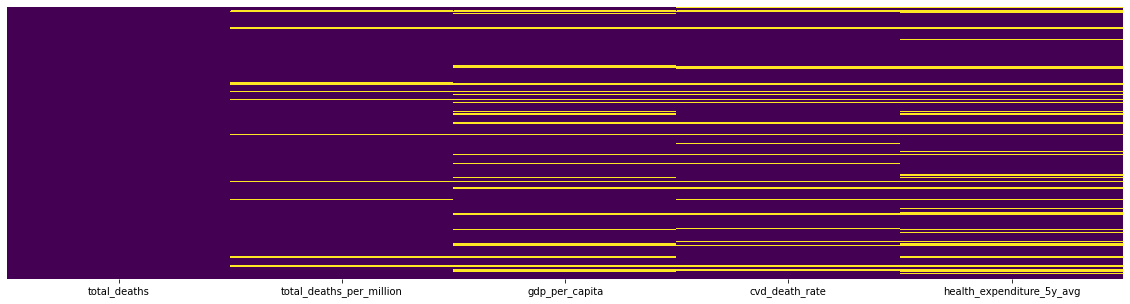

In [9]:
df_deaths.drop("smokers_percentage", axis=1, inplace=True)

print(df_deaths.dropna().shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_deaths.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_deaths.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Finally we export the data as a CSV file. We add the country labels again for better interpretation of data later.

In [10]:
df_deaths["iso_code"] = df_complete["iso_code"]
df_deaths["location"] = df_complete["location"]
df_deaths.dropna().to_csv('./computed/deaths.csv', sep=',', encoding='utf-8', index=False)